# Downloads

In [1]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.7 MB/s eta 0:00:00


In [2]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.7 MB/s eta 0:00:00


In [9]:
! git clone https://github.com/atahanoezer/Wind.git

Cloning into 'Wind'...
remote: Enumerating objects: 287, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 287 (delta 34), reused 25 (delta 10), pack-reused 221
Receiving objects: 100% (287/287), 25.81 MiB | 14.47 MiB/s, done.
Resolving deltas: 100% (126/126), done.


In [5]:
from kelmarsh_download import *

download_asset_data(asset="kelmarsh",outfile_path="datasets/UK/")
extract_all_data(path="datasets/UK/")


Title: Kelmarsh wind farm data
Version: 0.0.4
URL: https://zenodo.org/record/8252025
Record DOI: 10.5281/zenodo.7212475
License: CC-BY-4.0


Downloading: Kelmarsh_12.3MW_6xSenvion_MM92.kmz
File size: 0.04MB
Saved to: datasets/UK/Kelmarsh_12.3MW_6xSenvion_MM92.kmz


Downloading: Kelmarsh_era5.zip
File size: 7.75MB
Saved to: datasets/UK/Kelmarsh_era5.zip


Downloading: Kelmarsh_Grid_3088.zip
File size: 1.45MB
Saved to: datasets/UK/Kelmarsh_Grid_3088.zip


Downloading: Kelmarsh_merra2.zip
File size: 11.09MB
Saved to: datasets/UK/Kelmarsh_merra2.zip


Downloading: Kelmarsh_PMU_3089.zip
File size: 65.72MB
Saved to: datasets/UK/Kelmarsh_PMU_3089.zip


Downloading: Kelmarsh_SCADA_2016_3082.zip
File size: 93.38MB
Saved to: datasets/UK/Kelmarsh_SCADA_2016_3082.zip


Downloading: Kelmarsh_SCADA_2017_3083.zip
File size: 166.52MB
Saved to: datasets/UK/Kelmarsh_SCADA_2017_3083.zip


Downloading: Kelmarsh_SCADA_2018_3084.zip
File size: 250.01MB
Saved to: datasets/UK/Kelmarsh_SCADA_2018_3084.zip


Do

# Imports

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
%matplotlib inline
from datetime import datetime
from catboost import CatBoostRegressor


In [2]:
from Wind.dataset import Dataset
from Wind.utils import experiment_results
from Wind.model import *

In [3]:
import warnings
warnings.filterwarnings('ignore') # to avoid catboost and pd warnings

# Data Preprocess

In [4]:

# Change directory to the dataset
train_csv_1= 'datasets/UK/Turbine_Data_Kelmarsh_2_2018-01-01_-_2019-01-01_229.csv'
train_csv_2 = 'datasets/UK/Turbine_Data_Kelmarsh_2_2019-01-01_-_2020-01-01_229.csv'
val_csv = 'datasets/UK/Turbine_Data_Kelmarsh_2_2020-01-01_-_2021-01-01_229.csv'
test_csv = 'datasets/UK/Turbine_Data_Kelmarsh_2_2021-01-01_-_2021-07-01_229.csv'

csv_params = {'index_col':'# Date and time','parse_dates':True,'skiprows':9} # This part is copied from data provider check references

train_1 = pd.read_csv(train_csv_1,**csv_params)
train_2 = pd.read_csv(train_csv_2,**csv_params)
val = pd.read_csv(val_csv,**csv_params)
test = pd.read_csv(test_csv,**csv_params) #



concatenated_df = pd.concat([train_1,train_2,val,test]) # Concatanate test and train data
test_dates = concatenated_df[concatenated_df.index >= '2020-07-01'] # change test set to given test set
val_dates = concatenated_df[ (concatenated_df.index >= '2019-07-01') & (concatenated_df.index < '2020-07-01') ]


val_split = len(val_dates)/len(concatenated_df)
test_split = len(test_dates)/len(concatenated_df)

In [5]:
# This part is also copied from data provider, fields look good in terms of statistics
use_columns = [ 'Wind speed (m/s)','Wind speed, Standard deviation (m/s)', 'Wind speed, Minimum (m/s)',
            'Wind speed, Maximum (m/s)','Wind direction (°)','Nacelle position (°)','Energy Export (kWh)','Power (kW)',
            'Reactive power (kvar)','Rotor speed (RPM)','Generator RPM (RPM)','Nacelle ambient temperature (°C)',
            'Blade angle (pitch position) A (°)','Blade angle (pitch position) B (°)','Blade angle (pitch position) C (°)',
            'Lost Production to Curtailment (Total) (kWh)','Lost Production to Downtime (kWh)','Metal particle count counter',
            'Front bearing temperature (°C)','Rear bearing temperature (°C)']

In [6]:
roll_window = 4
dataset = Dataset(concatenated_df[use_columns])
dataset.fill_nan(use_columns)
dataset.add_seasonal_feat(dataset.df, dataset.df.index)
# Rolling means selected heuristicly
dataset.apply_rolling_window(dataset.df,'Wind speed (m/s)', roll_window,np.mean)
dataset.apply_rolling_window(dataset.df,'Nacelle ambient temperature (°C)', roll_window,np.mean)
dataset.apply_rolling_window(dataset.df,'Generator RPM (RPM)' , roll_window,np.mean)

# One-Shot Modelling

In [7]:
horizon = 1
window = 144

train_x,val_x, test_x, train_y,val_y, test_y,columns =dataset.create_dataset(dataset.df,
                                                                     window, horizon,target_col = 'Power (kW)',test_split= test_split,val_split = val_split,shuffle = True)

## Next Step Prediction

### Default

In [8]:
model = Model('cb',{'thread_count':4,'task_type':"GPU"})
model.train(train_x, train_y, val_x, val_y)

Learning rate set to 0.099478
0:	learn: 607.8578310	test: 610.2669333	best: 610.2669333 (0)	total: 6.49ms	remaining: 6.48s
500:	learn: 133.1623947	test: 143.7144137	best: 143.7144137 (500)	total: 2.46s	remaining: 2.45s
999:	learn: 123.8739061	test: 143.2849373	best: 143.2791351 (957)	total: 4.94s	remaining: 0us
bestTest = 143.2791351
bestIteration = 957
Shrink model to first 958 iterations.


                  MAE        RMSE        R2
Validation  91.325124  143.279144  0.954515
Test        90.257988  140.080843  0.956317


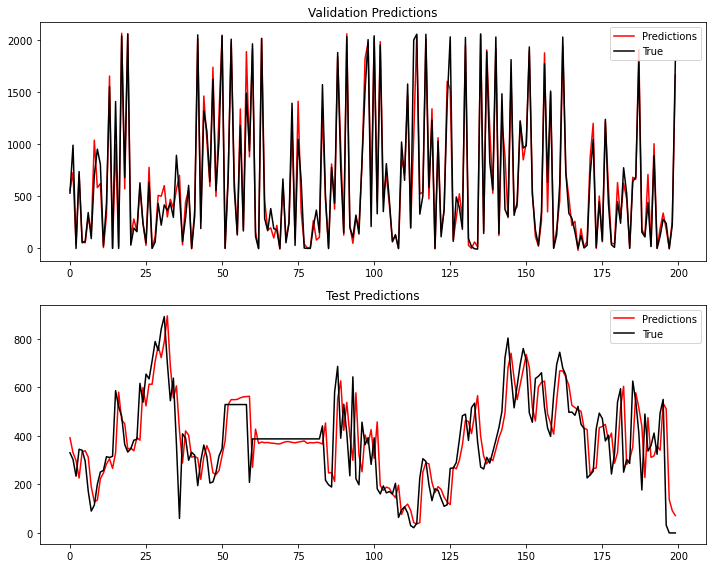

In [10]:
next_step_os,_=model.model_summarizer(val_x, val_y, test_x, test_y, plots=True,
plot_steps=200, feat_importance=False, feat_steps=15,feat_names=columns)



### Feat Select



In [11]:
model = Model('cb',{'thread_count':-1,'task_type':"GPU"})
feats = model.feat_select(val_x = val_x, val_y = val_y, train_x = train_x, train_y= train_y,num_feats =40,plot= False)
train_x,val_x,test_x = train_x[:,feats['selected_features']],val_x[:,feats['selected_features']],test_x[:,feats['selected_features']]

In [12]:
model.train(train_x, train_y, val_x, val_y)

Learning rate set to 0.099478
0:	learn: 608.0190314	test: 610.4467206	best: 610.4467206 (0)	total: 4.34ms	remaining: 4.34s
500:	learn: 131.5526656	test: 142.5417688	best: 142.5392740 (486)	total: 1.46s	remaining: 1.46s
999:	learn: 122.5612847	test: 142.1914422	best: 142.1645873 (907)	total: 2.95s	remaining: 0us
bestTest = 142.1645873
bestIteration = 907
Shrink model to first 908 iterations.


                  MAE        RMSE        R2
Validation  90.408849  142.164590  0.955220
Test        89.849138  139.897203  0.956431


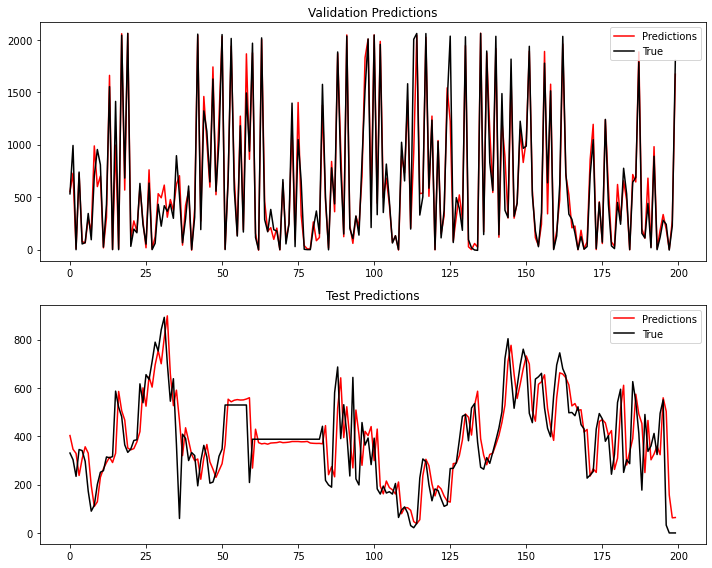

In [13]:
next_step_os_feat,_=model.model_summarizer(val_x, val_y, test_x, test_y, plots=True,
plot_steps=200, feat_importance=False, feat_steps=15,feat_names=columns)



### Hyp-op



In [14]:
model.hyp_op(val_x = val_x, val_y = val_y, train_x = train_x, train_y= train_y, task_type = 'GPU')

[I 2023-09-04 12:00:26,364] A new study created in memory with name: no-name-a1f4bb49-f3c3-418b-bae5-7c2e9c4f2ad3
[I 2023-09-04 12:00:29,028] Trial 0 finished with value: 119.47099373153259 and parameters: {'learning_rate': 0.0024924079397634358, 'depth': 5, 'min_data_in_leaf': 78}. Best is trial 0 with value: 119.47099373153259.
[I 2023-09-04 12:00:31,110] Trial 1 finished with value: 91.83675985173561 and parameters: {'learning_rate': 0.07070482621066827, 'depth': 3, 'min_data_in_leaf': 51}. Best is trial 1 with value: 91.83675985173561.
[I 2023-09-04 12:00:43,657] Trial 2 finished with value: 90.26640544377314 and parameters: {'learning_rate': 0.07679800470711719, 'depth': 10, 'min_data_in_leaf': 64}. Best is trial 2 with value: 90.26640544377314.
[I 2023-09-04 12:00:45,979] Trial 3 finished with value: 93.88915524092837 and parameters: {'learning_rate': 0.007476554790364022, 'depth': 4, 'min_data_in_leaf': 71}. Best is trial 2 with value: 90.26640544377314.
[I 2023-09-04 12:00:49,4

Best hyperparameters: {'learning_rate': 0.06296795652063984, 'depth': 9, 'min_data_in_leaf': 61}
Best RMSE: 90.07882745115644


({'learning_rate': 0.06296795652063984, 'depth': 9, 'min_data_in_leaf': 61},
 90.07882745115644)

                  MAE        RMSE        R2
Validation  95.148150  147.122667  0.952042
Test        93.945079  143.623652  0.954079


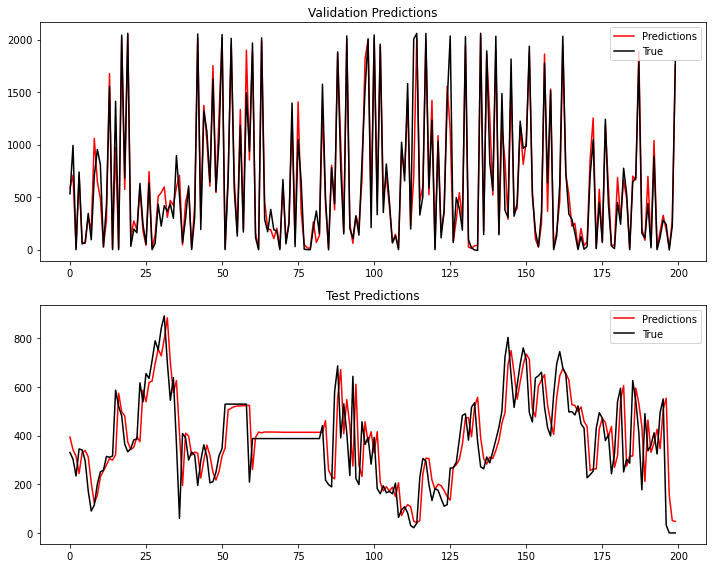

In [15]:
next_step_os_feat_hy,_=model.model_summarizer(val_x, val_y, test_x, test_y, plots=True,
plot_steps=200, feat_importance=False, feat_steps=15,feat_names=columns)



## Next Hour Prediction



In [16]:
horizon = 6
window = 144
train_x,val_x, test_x, train_y,val_y, test_y,columns =dataset.create_dataset(dataset.df,
                              window, horizon,target_col = 'Power (kW)',test_split= test_split,val_split = val_split)

### Default

In [17]:
model = Model('cb',{'thread_count':-1,'task_type':"GPU"})
model.train(train_x, train_y[:,-1], val_x, val_y[:,-1],multioutput=False)

Learning rate set to 0.099482
0:	learn: 609.8279926	test: 627.8108927	best: 627.8108927 (0)	total: 7ms	remaining: 6.99s
500:	learn: 226.3351887	test: 278.0112177	best: 272.4580759 (66)	total: 2.51s	remaining: 2.5s
999:	learn: 204.8494843	test: 282.3428738	best: 272.4580759 (66)	total: 5.01s	remaining: 0us
bestTest = 272.4580759
bestIteration = 66
Shrink model to first 67 iterations.


                   MAE        RMSE        R2
Validation  187.526838  272.458085  0.839296
Test        174.836120  251.791051  0.858874


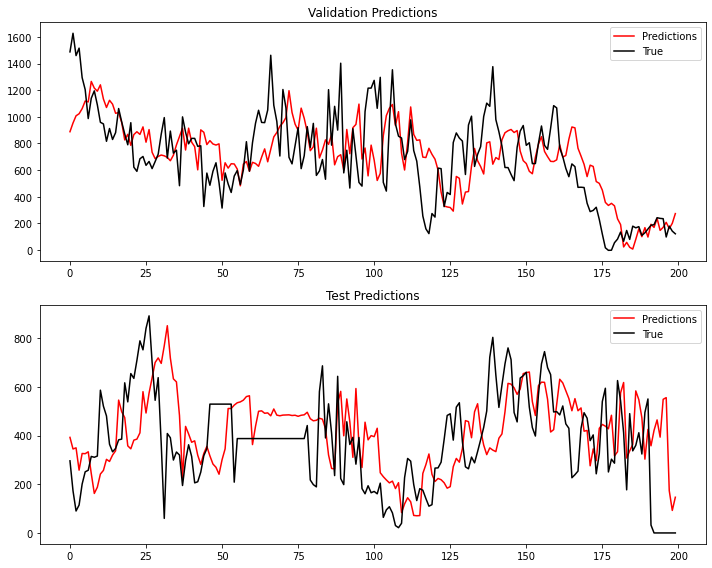

In [18]:
next_hour_os,_=model.model_summarizer(val_x, val_y[:,-1], test_x, test_y[:,-1], plots=True,
plot_steps=200, feat_importance=False, feat_steps=15,feat_names= columns)

### Feat Select

In [19]:
model = Model('cb',{'thread_count':-1,'task_type':"GPU"})
feats = model.feat_select(val_x = val_x, val_y = val_y[:,-1], train_x = train_x, train_y= train_y[:,-1],num_feats =40,plot= False)
train_x,val_x,test_x = train_x[:,feats['selected_features']],val_x[:,feats['selected_features']],test_x[:,feats['selected_features']]


In [20]:
model.train(train_x, train_y[:,-1], val_x, val_y[:,-1])

Learning rate set to 0.099482
0:	learn: 609.8692882	test: 627.8575334	best: 627.8575334 (0)	total: 3.65ms	remaining: 3.65s
500:	learn: 229.5869766	test: 274.5336481	best: 272.3581146 (87)	total: 1.38s	remaining: 1.38s
999:	learn: 211.1497483	test: 276.6224560	best: 272.3581146 (87)	total: 2.72s	remaining: 0us
bestTest = 272.3581146
bestIteration = 87
Shrink model to first 88 iterations.


                   MAE        RMSE        R2
Validation  186.985613  272.358119  0.839414
Test        174.404193  251.400260  0.859311


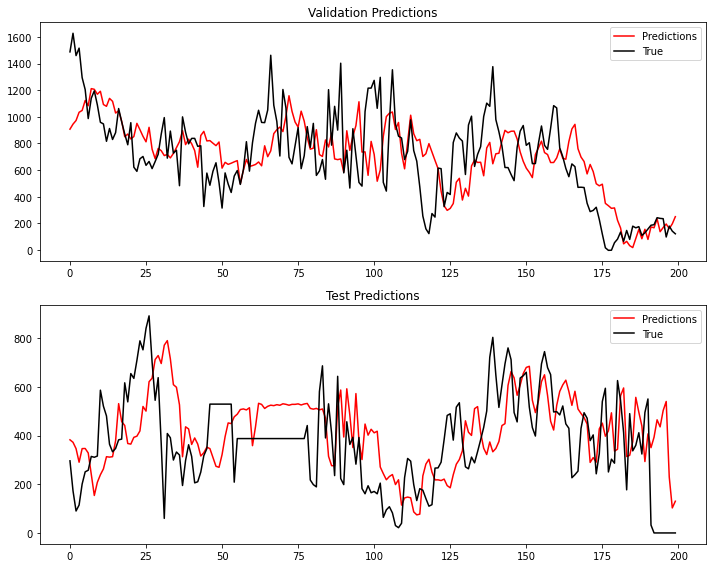

In [21]:
next_hour_os_feat,_=model.model_summarizer(val_x, val_y[:,-1], test_x, test_y[:,-1], plots=True,
plot_steps=200, feat_importance=False, feat_steps=15,feat_names= columns)

### Hyp-op

In [22]:
model.hyp_op(val_x = val_x, val_y = val_y[:,-1], train_x = train_x, train_y= train_y[:,-1])

[I 2023-09-04 12:05:05,060] A new study created in memory with name: no-name-f5775d4d-1f5b-4bb4-af4a-1bdbd6d432d2
[I 2023-09-04 12:05:07,598] Trial 0 finished with value: 186.81383097832392 and parameters: {'learning_rate': 0.054669170750836514, 'depth': 5, 'min_data_in_leaf': 71}. Best is trial 0 with value: 186.81383097832392.
[I 2023-09-04 12:05:10,884] Trial 1 finished with value: 191.8725923555487 and parameters: {'learning_rate': 0.0038519664125726354, 'depth': 6, 'min_data_in_leaf': 16}. Best is trial 0 with value: 186.81383097832392.
[I 2023-09-04 12:05:14,100] Trial 2 finished with value: 188.14145478971574 and parameters: {'learning_rate': 0.00528553455853888, 'depth': 6, 'min_data_in_leaf': 43}. Best is trial 0 with value: 186.81383097832392.
[I 2023-09-04 12:05:15,723] Trial 3 finished with value: 187.78254779906925 and parameters: {'learning_rate': 0.06639283846719393, 'depth': 2, 'min_data_in_leaf': 26}. Best is trial 0 with value: 186.81383097832392.
[I 2023-09-04 12:05:

Best hyperparameters: {'learning_rate': 0.013833992142699262, 'depth': 5, 'min_data_in_leaf': 37}
Best RMSE: 186.66376277390867


({'learning_rate': 0.013833992142699262, 'depth': 5, 'min_data_in_leaf': 37},
 186.66376277390867)

                   MAE        RMSE        R2
Validation  187.424593  272.111183  0.839705
Test        174.952894  251.308132  0.859414


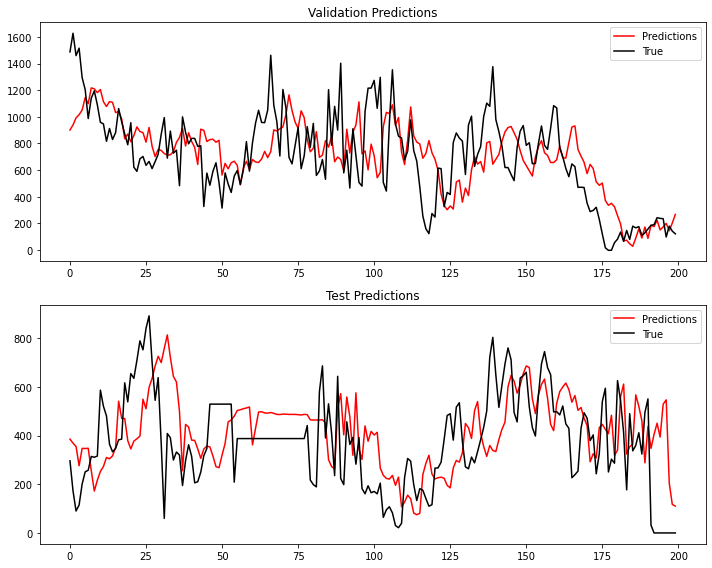

In [23]:
next_hour_os_feat_hy,_=model.model_summarizer(val_x, val_y[:,-1], test_x, test_y[:,-1], plots=True,
plot_steps=200, feat_importance=False, feat_steps=15,feat_names= columns)



## Next Day Prediction



In [24]:
train_x,val_x, test_x, train_y,val_y, test_y,columns =dataset.create_dataset(dataset.df,
                                                                     144, 144,target_col ='Power (kW)',test_split= test_split,val_split = val_split)

### Default

In [25]:
model = Model('cb',{'thread_count':-1,'task_type':"GPU"})
model.train(train_x, train_y[:,-1], val_x, val_y[:,-1],multioutput=False)

Learning rate set to 0.099463
0:	learn: 645.0596532	test: 669.2424485	best: 669.2424485 (0)	total: 6.84ms	remaining: 6.83s
500:	learn: 349.2215976	test: 695.8004187	best: 613.2523708 (26)	total: 2.52s	remaining: 2.51s
999:	learn: 288.1616265	test: 706.6697175	best: 613.2523708 (26)	total: 4.98s	remaining: 0us
bestTest = 613.2523708
bestIteration = 26
Shrink model to first 27 iterations.


                   MAE        RMSE        R2
Validation  507.266677  613.252352  0.187583
Test        521.038631  627.725366  0.124448


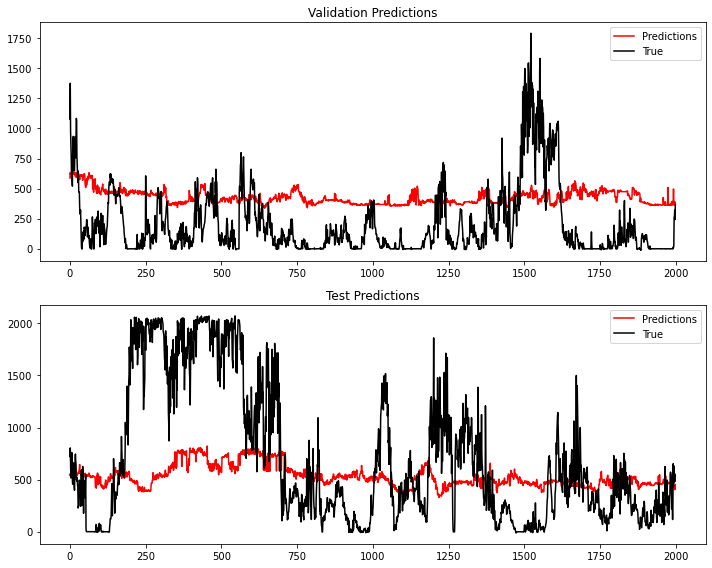

In [26]:
next_day_os,_=model.model_summarizer(val_x, val_y[:,-1], test_x, test_y[:,-1], plots=True,
plot_steps=2000, feat_importance=False, feat_steps=15,feat_names= columns)

### Feat Select

In [27]:
model = Model('cb',{'thread_count':-1,'task_type':"GPU"})

feats = model.feat_select(val_x = val_x, val_y = val_y[:,-1], train_x = train_x, train_y= train_y[:,-1],num_feats =40,plot= False)
train_x,val_x,test_x = train_x[:,feats['selected_features']],val_x[:,feats['selected_features']],test_x[:,feats['selected_features']]

In [28]:
model.train(train_x, train_y[:,-1], val_x, val_y[:,-1],multioutput=False)

Learning rate set to 0.099463
0:	learn: 645.3111458	test: 669.4175847	best: 669.4175847 (0)	total: 3.72ms	remaining: 3.72s
500:	learn: 371.3864028	test: 663.1274319	best: 604.9482430 (24)	total: 1.46s	remaining: 1.45s
999:	learn: 313.6517037	test: 680.9853601	best: 604.9482430 (24)	total: 2.9s	remaining: 0us
bestTest = 604.948243
bestIteration = 24
Shrink model to first 25 iterations.


                   MAE        RMSE        R2
Validation  493.420868  604.948266  0.209436
Test        503.041137  613.066578  0.164863


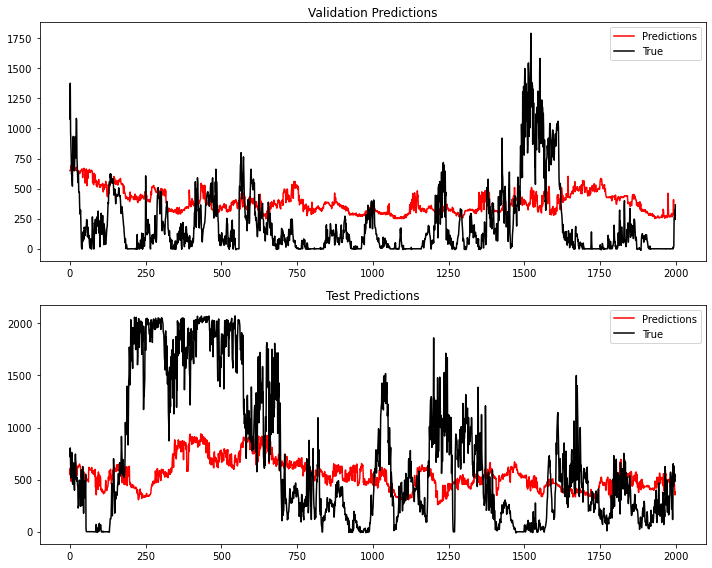

In [29]:
next_day_os_feat,_=model.model_summarizer(val_x, val_y[:,-1], test_x, test_y[:,-1], plots=True,
plot_steps=2000, feat_importance=False, feat_steps=15,feat_names= columns)

### Hyp-op

In [30]:
model.hyp_op(val_x = val_x, val_y = val_y[:,-1], train_x = train_x, train_y= train_y[:,-1])

[I 2023-09-04 12:09:53,565] A new study created in memory with name: no-name-4e91bb12-34ab-4c95-87ea-110fcc6d23a3
[I 2023-09-04 12:09:57,644] Trial 0 finished with value: 493.12778821119235 and parameters: {'learning_rate': 0.007751383167427423, 'depth': 7, 'min_data_in_leaf': 12}. Best is trial 0 with value: 493.12778821119235.
[I 2023-09-04 12:10:00,484] Trial 1 finished with value: 513.2454804791431 and parameters: {'learning_rate': 0.0010782819225114975, 'depth': 5, 'min_data_in_leaf': 46}. Best is trial 0 with value: 493.12778821119235.
[I 2023-09-04 12:10:03,886] Trial 2 finished with value: 492.5518801678304 and parameters: {'learning_rate': 0.014590268588024154, 'depth': 6, 'min_data_in_leaf': 63}. Best is trial 2 with value: 492.5518801678304.
[I 2023-09-04 12:10:08,171] Trial 3 finished with value: 494.5405575402993 and parameters: {'learning_rate': 0.015458065148602379, 'depth': 7, 'min_data_in_leaf': 42}. Best is trial 2 with value: 492.5518801678304.
[I 2023-09-04 12:10:10

Best hyperparameters: {'learning_rate': 0.06902725356401068, 'depth': 2, 'min_data_in_leaf': 83}
Best RMSE: 489.6590029391594


({'learning_rate': 0.06902725356401068, 'depth': 2, 'min_data_in_leaf': 83},
 489.6590029391594)

                   MAE        RMSE        R2
Validation  491.315969  604.600079  0.210346
Test        496.410775  606.829402  0.181769


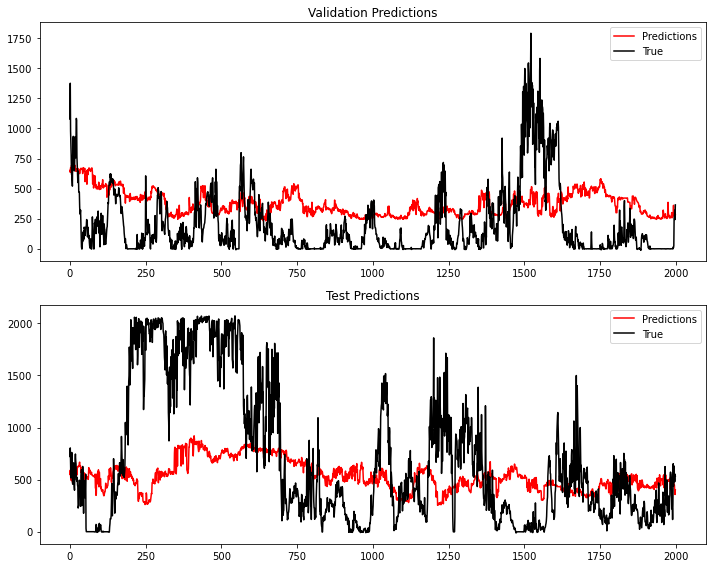

In [31]:
next_day_os_feat_hy,_=model.model_summarizer(val_x, val_y[:,-1], test_x, test_y[:,-1], plots=True,
plot_steps=2000, feat_importance=False, feat_steps=15,feat_names= columns)

# Recursive Modelling

## Next Hour Prediction

In [35]:
train_x,val_x, test_x, train_y,val_y, test_y,columns =dataset.create_dataset(dataset.df,
                                                                     144, 6,target_col ='Power (kW)',test_split = test_split,val_split = val_split,univariate= True)

In [36]:
model = Model('cb',{'thread_count':-1,'task_type':"GPU",'learning_rate': 0.04564318003506682, 'depth': 9, 'min_data_in_leaf': 28},prediction_type = 'recursive')
model.train(train_x, train_y[:,0], val_x, val_y[:,0],multioutput=False)

0:	learn: 634.9057632	test: 652.6560391	best: 652.6560391 (0)	total: 17.1ms	remaining: 17.1s
500:	learn: 134.8160190	test: 150.5708676	best: 150.4457989 (257)	total: 7.91s	remaining: 7.88s
999:	learn: 121.9128184	test: 150.9566028	best: 150.4457989 (257)	total: 16.1s	remaining: 0us
bestTest = 150.4457989
bestIteration = 257
Shrink model to first 258 iterations.


                   MAE        RMSE        R2
Validation  112.325289  165.870722  0.940438
Test        104.926494  156.903166  0.945196


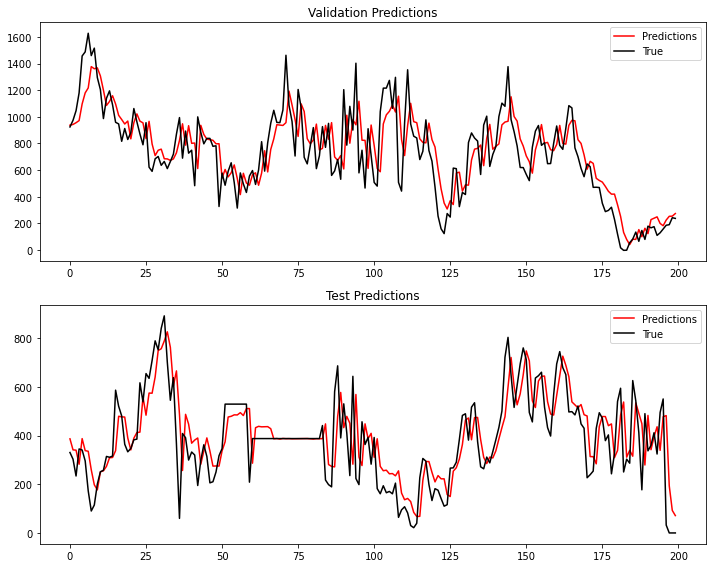

In [37]:
next_hour_rec,_=model.model_summarizer(val_x, val_y[:,0], test_x, test_y[:,0], plots=True,
plot_steps=200, feat_importance=False, feat_steps=15,feat_names= columns,horizon =6)

## Next Day Prediction

In [38]:
train_x,val_x, test_x, train_y,val_y, test_y,columns =dataset.create_dataset(dataset.df,
                                                                     144, 144,target_col ='Power (kW)',test_split= test_split, val_split= val_split ,univariate=True)

In [39]:

model = Model('cb',{'thread_count':-1,'task_type':"GPU",'learning_rate': 0.04564318003506682, 'depth': 9, 'min_data_in_leaf': 28},prediction_type = 'recursive')
model.train(train_x, train_y[:,0], val_x, val_y[:,0], multioutput= False)

0:	learn: 635.2268078	test: 653.3189923	best: 653.3189923 (0)	total: 16.8ms	remaining: 16.8s
500:	learn: 134.6247351	test: 150.5044023	best: 150.3883501 (204)	total: 7.86s	remaining: 7.83s
999:	learn: 121.8975510	test: 150.8668180	best: 150.3883501 (204)	total: 15.8s	remaining: 0us
bestTest = 150.3883501
bestIteration = 204
Shrink model to first 205 iterations.


                   MAE        RMSE        R2
Validation  180.921435  266.728058  0.846262
Test        163.794949  247.325552  0.863914


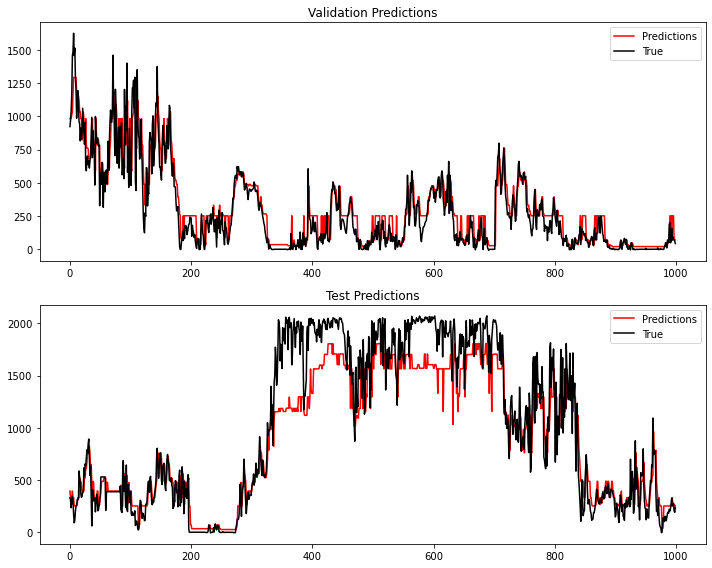

In [44]:
next_day_rec,_=model.model_summarizer(val_x, val_y[:,0], test_x, test_y[:,0], plots=True,
plot_steps=1000, feat_importance=False, feat_steps=15,feat_names= columns,horizon =144)

# Result Comparison

In [41]:
next_step_baseline = {'MAE': 91.554 , 'RMSE': 145.603, 'R2':0 }
results = [next_step_baseline,next_step_os.iloc[1,:],next_step_os_feat.iloc[1,:],next_step_os_feat_hy.iloc[1,:]]

names = ['Baseline', ' One Shot', ' One Shot Feat', ' One Shot Feat + Hyp-op']

experiment_results(names, results,title = 'Next Step Prediction')

| Metric                 | MAE        | RMSE        | R2        |
|:-----------------------|:-----------|:------------|:----------|
| Next Step Prediction   |            |             |           |
| Baseline               | 91.554     | 145.603     | -         |
| One Shot               | 90.258     | 140.081     | 0.956     |
| One Shot Feat          | **89.849** | **139.897** | **0.956** |
| One Shot Feat + Hyp-op | 93.945     | 143.624     | 0.954     |


In [42]:
next_hour_baseline = {'MAE': 183.286 , 'RMSE': 263.749	, 'R2':0 }
results = [next_hour_baseline,next_hour_os.iloc[1,:],next_hour_os_feat.iloc[1,:],next_hour_os_feat_hy.iloc[1,:],next_hour_rec.iloc[1,:]]

names = ['Baseline', ' One Shot', ' One Shot Feat', ' One Shot Feat + Hyp-op', 'Recursive']

experiment_results(names, results,title = 'Next Hour Prediction')

| Metric                 | MAE         | RMSE        | R2        |
|:-----------------------|:------------|:------------|:----------|
| Next Hour Prediction   |             |             |           |
| Baseline               | 183.286     | 263.749     | -         |
| One Shot               | 174.836     | 251.791     | 0.859     |
| One Shot Feat          | 174.404     | 251.4       | 0.859     |
| One Shot Feat + Hyp-op | 174.953     | 251.308     | 0.859     |
| Recursive              | **104.926** | **156.903** | **0.945** |


In [43]:
next_day_baseline = {'MAE': 510.710 , 'RMSE': 623.023	, 'R2':0 }
results = [next_day_baseline,next_day_os.iloc[1,:],next_day_os_feat.iloc[1,:],next_day_os_feat_hy.iloc[1,:], next_day_rec.iloc[1,:]]

names = ['Baseline', ' One Shot', ' One Shot Feat', ' One Shot Feat + Hyp-op', 'Recursive']

experiment_results(names, results,title = 'Next Day Prediction')

| Metric                 | MAE         | RMSE        | R2        |
|:-----------------------|:------------|:------------|:----------|
| Next Day Prediction    |             |             |           |
| Baseline               | 510.71      | 623.023     | -         |
| One Shot               | 521.039     | 627.725     | 0.124     |
| One Shot Feat          | 503.041     | 613.067     | 0.165     |
| One Shot Feat + Hyp-op | 496.411     | 606.829     | 0.182     |
| Recursive              | **163.795** | **247.326** | **0.864** |
